<a href="https://colab.research.google.com/github/RadSpiral/certified_machine_unlearning/blob/main/Figure_1_new_logistic_ridge_n_p_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.linalg
import statsmodels.api as sm
from scipy.stats import gamma

def sample_b(p, C):
    # Step 1: Sample r ~ Gamma(p, scale=1/C)
    r = gamma.rvs(a=p, scale=1/C)

    # Step 2: Sample a unit vector u ~ Uniform(S^(p-1))
    u = np.random.randn(p)
    u /= np.linalg.norm(u)  # Normalize to unit sphere

    # Step 3: Scale the unit vector
    b = r * u
    return b

# Logistic Ridge Regression Functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(beta, X, y, lambda_):
    n              = X.shape[0]
    logits         = X @ beta
    log_likelihood = -np.mean(y * logits - np.log(1 + np.exp(logits)))
    ridge_penalty  = 0.5 * lambda_ * np.sum(beta**2) / n
    return log_likelihood + ridge_penalty

def gradient(beta, X, y, lambda_):
    pr = sigmoid(X @ beta)
    return -X.T @ (y - pr) + lambda_ * beta

def hessian(beta, X, lambda_):
    pr = sigmoid(X @ beta)
    W = np.diag(pr * (1 - pr))
    return X.T @ W @ X + lambda_ * np.eye(X.shape[1])


def conjugate_gradient_logistic(X, y, beta, z_init, lambda_, tol=1e-8, max_iter=1000000):
    """
    Conjugate Gradient solver for logistic ridge regression Newton step:
    Solves H @ z = -grad without forming H or grad explicitly.

    Args:
        X        : (n x p) design matrix
        y        : (n,) binary labels
        beta     : (p,) current beta vector
        z_init   : (p,) initial guess for solution z
        lambda_  : regularization parameter
        tol      : tolerance for convergence
        max_iter : max number of CG iterations

    Returns:
        z : solution to H @ z = -grad
    """
    n, d = X.shape
    pr = sigmoid(X @ beta)

    # Hessian-vector product
    def Hv(v):
        Xv = X @ v
        W_Xv = (pr * (1 - pr)) * Xv
        return X.T @ W_Xv + lambda_ * v

    # Gradient vector
    grad = -X.T @ (y - pr) + lambda_ * beta

    # Conjugate gradient to solve H @ z = -grad
    z = z_init.copy()
    r = -grad - Hv(z)
    d_vec = r.copy()
    r_dot_old = np.dot(r, r)

    for cg_count in range(1, max_iter+1):
        Hd = Hv(d_vec)
        alpha = r_dot_old / np.dot(d_vec, Hd)
        z += alpha * d_vec
        r -= alpha * Hd
        r_dot_new = np.dot(r, r)
        if np.sqrt(r_dot_new) < tol:
            break
        beta_cg = r_dot_new / r_dot_old
        d_vec = r + beta_cg * d_vec
        r_dot_old = r_dot_new
    return z, cg_count


def newton_step(beta_init, X, y, lambda_, tol=1e-6, max_iter=100, cg=False, cg_tol=1e-16):
    beta = beta_init.copy()
    for step_count in range(1, max_iter + 1):
        if cg:
          z_init    = 0.00 * np.random.randn(len(beta))
          z, cg_count         = conjugate_gradient_logistic(X, y, beta, z_init, lambda_, tol=cg_tol) # computes -hess^{-1} * grad
          #hess      = hessian(beta, X, lambda_)
          #grad      = gradient(beta, X, y, lambda_)
          #z_alt     = -np.linalg.solve(hess, grad)
          #print(f"sum |z - z_alt|/sum|z_alt| = {np.sum(np.abs(z - z_alt))/np.sum(np.abs(z_alt)):.10f}")
        else:
          grad = gradient(beta, X, y, lambda_)
          hess = hessian(beta, X, lambda_)
          z    = -np.linalg.solve(hess, grad)
        beta += z
        if np.linalg.norm(z) < tol:
            return beta, step_count
    return beta, max_iter

# Main code
np.random.seed(0)
#logp_     = np.arange(start=2, stop=7, step=1)
#plogstep  = 10 ** 0.2
#p_        = np.floor(360 * plogstep ** logp_).astype(int)
p_ = np.array([2500])
delta     = 0.5  # n/p
lambda_   = 1  # Ridge regularization
#nn        = 100
nn        = int(p_[0] * delta)
e         = 0.1
cg_tol    = 1e-18
newton_tol= 1e-3
cg        = True
cg_count  = 0
#  Initialization
meanErr_tilde     = np.zeros(len(p_))
sdErr_tilde       = np.zeros(len(p_))
meanErr_tilde_2   = np.zeros(len(p_))
sdErr_tilde_2     = np.zeros(len(p_))
meanErr_hat       = np.zeros(len(p_))
sdErr_hat         = np.zeros(len(p_))

loss_hat          = np.zeros((nn, len(p_))) # loss of the exact unlearned model, tested on the unlearned datapoint
loss_tilde        = np.zeros((nn, len(p_))) # loss of the one Newton step unlearned model, tested on the unlearned datapoint
loss_tilde_2      = np.zeros((nn, len(p_))) # loss of the two Newton step unlearned model, tested on the unlearned datapoint
loss_Guo          = np.zeros((nn, len(p_))) # loss of the one Newton step + noise GUO 2019 unlearned model, tested on the unlearned datapoint

loss_new_hat      = np.zeros((nn, len(p_))) # loss of the exact unlearned model, tested on the unlearned datapoint
loss_new_tilde    = np.zeros((nn, len(p_))) # loss of the one Newton step unlearned model, tested on  many new datapoints
loss_new_tilde_2  = np.zeros((nn, len(p_))) # loss of the two Newton step unlearned model, tested on  many new datapoints


for i, p in enumerate(p_):
    beta_star = np.random.normal(0, 1, p)
    n         = int(p * delta)  # Define `n` based on `delta`
    X         = np.random.normal(0, 1 / np.sqrt(n), (n, p))
    logits    = X @ beta_star
    prob      = sigmoid(logits)
    y         = np.random.binomial(1, prob)

    beta_init            = np.random.normal(0, 1, p) * 0.001
    beta_hat, steps_used = newton_step(beta_init, X, y, lambda_, tol=newton_tol, cg=cg, cg_tol=cg_tol)

    if i==0:
      p_hat     = sigmoid(X @ beta_hat)
      W         = np.diag(p_hat * (1 - p_hat))
      # Use pseudo-inverse to prevent singular matrix error
      hess_inv  = scipy.linalg.pinv(hessian(beta_hat, X, lambda_))
      H         = X @ hess_inv @ X.T @ W
      tr_H      = np.trace(H) / p

    err_tilde   = np.zeros(nn)
    err_tilde_2 = np.zeros(nn)
    err_hat     = np.zeros(nn)

    for j in range(nn):
        X_j_out = np.delete(X, j, axis=0)
        y_j_out = np.delete(y, j)

        # ---------------------------- GUO 2019 analysis - BEGIN ----------------------------
        H_minus_j  = hessian(beta_hat, X_j_out, lambda_)
        Delta = (lambda_ / n) * beta_hat + (sigmoid(X[j, :] @ beta_hat) - y[j]) * X[j, :]
        # Delta = (lambda_/n) * beta_hat + gradient(beta_hat, X[j,], y[j], 0)
        # w^- = w* + H^{-1} Δ
        # Use a stable solve; fall back to pinv if needed
        try:
            step_j = np.linalg.solve(H_minus_j, Delta)
        except np.linalg.LinAlgError:
            step_j = scipy.linalg.pinv(H_minus_j) @ Delta
        beta_star_j      = beta_hat + step_j
        residual_minus_j = sigmoid(X_j_out @ beta_star_j) - y_j_out
        nabla_L_minus_j  = X_j_out.T @ residual_minus_j + lambda_ * (1.0 - 1.0 / n) * beta_star_j
        eps_prime        = np.linalg.norm(nabla_L_minus_j, 2)
        # Parameters and noise scale
        delta_Guo   = 1e-4
        c_Guo       = np.sqrt(2.0 * np.log(1.5 / delta_Guo))
        epsilon_Guo = 0.1
        sigma_Guo   = c_Guo * eps_prime / epsilon_Guo
        # sigma_Guo = 10
        debug = False
        if debug:
              gamma = 0.25  # Lipschitz constant
              beta_constant_Guo = gamma * np.sqrt(np.linalg.norm(X_j_out, 2)) * np.linalg.norm(step_j, 2) * np.linalg.norm(X_j_out @ step_j, 2)

              lhs = beta_constant_Guo
              rhs = sigma_Guo * epsilon_Guo / c_Guo
              if lhs > rhs:
                  print(f"β ({lhs:.4e}) > σϵ/c ({rhs:.4e}) ❌")
              else:
                  print(f"β ({lhs:.4e}) <= σϵ/c ({rhs:.4e}) ✅")


        # Draw b ~ N(0, σ)^d
        b_Guo = np.random.normal(loc=0.0, scale=sigma_Guo, size=p)
        # --- Solve w_b = argmin_w L_b(w, D) ---
        beta_hat_b = np.zeros(p)
        tol = 1e-8
        max_iter = 1000

        for _ in range(max_iter):
            # logistic model predictions
            pr = sigmoid(X @ beta_hat_b)
            # gradient of L_b(w,D)
            grad_log = -X.T @ (y - pr)
            grad_ridge = lambda_ * beta_hat_b
            grad_linear = b_Guo
            grad_b = grad_log + grad_ridge + grad_linear
            # Hessian of L_b(w,D)
            Wb = pr * (1 - pr)
            Hb = X.T @ (Wb[:, None] * X) + lambda_ * np.eye(p)
            # Newton update
            try:
                step = -np.linalg.solve(Hb, grad_b)
            except np.linalg.LinAlgError:
                step = -scipy.linalg.pinv(Hb) @ grad_b
            beta_hat_b += step
            if np.linalg.norm(step) < tol:
                break

        H_minus_j  = hessian(beta_hat_b, X_j_out, lambda_)
        Delta_b = (lambda_ / n) * beta_hat_b + (sigmoid(X[j, :] @ beta_hat_b) - y[j]) * X[j, :]
        #Delta_b = (lambda_/n) * beta_hat_b + gradient(beta_hat_b, X[j,], y[j], 0)
        # w^- = w* + H^{-1} Δ
        # Use a stable solve; fall back to pinv if needed
        try:
            step_j = np.linalg.solve(H_minus_j, Delta_b)
        except np.linalg.LinAlgError:
            step_j = scipy.linalg.pinv(H_minus_j) @ Delta_b
        beta_star_j      = beta_hat_b + step_j
        loss_Guo[j, i]   = loss(beta_star_j, X[j, :], y[j], lambda_=0)
        # ---------------------------- GU0 2019 analysis - END ----------------------------

        beta_init              = 0.00 * np.random.randn(p)
        beta_hat_j, steps_used = newton_step(beta_init, X_j_out, y_j_out, lambda_, tol=newton_tol, cg=cg, cg_tol=cg_tol)
        err_hat[j]             = np.linalg.norm(beta_hat - beta_hat_j)

        #  beta tilde calculation
        if cg:
          z_init                 = 0.00 * np.random.randn(p)
          z, cg_count            = conjugate_gradient_logistic(X_j_out, y_j_out, beta_hat, z_init, lambda_, tol=cg_tol) # computes -hess^{-1} * grad
          #hess_j_out_hat         = hessian(beta_hat, X_j_out, lambda_)
          #grad_j_out_hat         = gradient(beta_hat, X_j_out, y_j_out, lambda_)
          #z                      = -np.linalg.solve(hess_j_out_hat, grad_j_out_hat)
          #print(f"sum |z - z_alt|/sum|z_alt| = {np.sum(np.abs(z - z_alt))/np.sum(np.abs(z_alt)):.10f}")
        else:
          hess_j_out_hat         = hessian(beta_hat, X_j_out, lambda_)
          grad_j_out_hat         = gradient(beta_hat, X_j_out, y_j_out, lambda_)
          z                      = -np.linalg.solve(hess_j_out_hat, grad_j_out_hat)

        beta_tld_j             = beta_hat + z
        err_tilde[j]           = np.linalg.norm(beta_tld_j - beta_hat_j)

        #  beta tilde 2 calculation
        if cg:
          z_init                 = 0.00 * np.random.randn(p)
          z, cg_count            = conjugate_gradient_logistic(X_j_out, y_j_out, beta_tld_j, z_init, lambda_, tol=cg_tol) # computes -hess^{-1} * grad
          #hess_j_out_tilde       = hessian(beta_tld_j, X_j_out, lambda_)
          #grad_j_out_tilde       = gradient(beta_tld_j, X_j_out, y_j_out, lambda_)
          #z                      = -np.linalg.solve(hess_j_out_tilde, grad_j_out_tilde)
          #print(f"sum |z - z_alt|/sum|z_alt| = {np.sum(np.abs(z - z_alt))/np.sum(np.abs(z_alt)):.6f}")
        else:
          hess_j_out_tilde       = hessian(beta_tld_j, X_j_out, lambda_)
          grad_j_out_tilde       = gradient(beta_tld_j, X_j_out, y_j_out, lambda_)
          z                      = - np.linalg.solve(hess_j_out_tilde, grad_j_out_tilde)
        beta_tld_j_2           = beta_tld_j + z
        err_tilde_2[j]         = np.linalg.norm(beta_tld_j_2 - beta_hat_j)

    print(f"---------------- n = {n}, p = {p},  df/p = {tr_H:.2f}, lambda = {lambda_}, cg_count = {cg_count}, newton steps: {steps_used} ----------------")
    meanErr_tilde[i]   = np.mean(err_tilde)
    sdErr_tilde[i]     = np.std(err_tilde) / np.sqrt(nn)
    meanErr_tilde_2[i] = np.mean(err_tilde_2)
    sdErr_tilde_2[i]   = np.std(err_tilde_2) / np.sqrt(nn)
    meanErr_hat[i]     = np.mean(err_hat)
    sdErr_hat[i]       = np.std(err_hat) / np.sqrt(nn)
    # Linear regression log(error) vs log(m)
    if i > 1:
      log_p = np.log(p_[:i+1])
      X_reg = sm.add_constant(log_p)
      def fit_model(errors):
        return sm.OLS(np.log(errors), X_reg).fit()
      models = {
          "tilde": fit_model(meanErr_tilde[:i+1]),
          "tilde_2": fit_model(meanErr_tilde_2[:i+1]),
          "hat": fit_model(meanErr_hat[:i+1]),
      }
      results = {
          name: {
              "slope": model.params[1],
              "conf_int": model.conf_int()[1],
              "R2": model.rsquared,
              }
              for name, model in models.items()
      }
      print(f"   "
        f"1 step: slope={results['tilde']['slope']:.2f}, "
        f"CI=({results['tilde']['conf_int'][0]:6.2f},{results['tilde']['conf_int'][1]:6.2f}), R²={results['tilde']['R2']:.2f} | "
        f"| 2 step: slope={results['tilde_2']['slope']:.2f}, "
        f"CI=({results['tilde_2']['conf_int'][0]:6.2f},{results['tilde_2']['conf_int'][1]:6.2f}), R²={results['tilde_2']['R2']:.2f} | "
        f"| exact: slope={results['hat']['slope']:.2f}, "
        f"CI=({results['hat']['conf_int'][0]:6.2f},{results['hat']['conf_int'][1]:6.2f}), R²={results['hat']['R2']:.2f} |")
      print("--------------------------------------------------------------------------------------------------------------------------------")

    rmax1             = np.max(err_tilde)    *  np.sqrt(np.log(n) / np.log(nn))
    rmax2             = np.max(err_tilde_2)  *  np.sqrt(np.log(n) / np.log(nn))
    n_new             = 1
    #print(f"---------------- np.max(err_tilde) = {np.max(err_tilde):.7f}, np.max(err_tilde_2)= {np.max(err_tilde_2):.7f} ----------------")
    #print(f"---------------- rmax1 = {rmax1:.7f}, rmax2 = {rmax2:.7f}---------------- ")

    for j in range(nn):
        X_j_out                = np.delete(X, j, axis=0)
        y_j_out                = np.delete(y, j)

        X_new                  = np.random.normal(0, 1 / np.sqrt(n), (n_new, p))
        logits_new             = X_new @ beta_star
        prob_new               = sigmoid(logits_new)
        y_new                  = np.random.binomial(1, prob_new)
        # exact unlearned model
        beta_init              = 0.00 * np.random.randn(p)
        beta_hat_j, steps_used = newton_step(beta_init, X_j_out, y_j_out, lambda_, tol=newton_tol, cg=cg, cg_tol=cg_tol)
        loss_hat[j, i]         = loss(beta_hat_j, X[j, :], y[j], lambda_=0)
        loss_new_hat[j, i]     = loss(beta_hat_j, X_new, y_new, lambda_=0)

        #  one Newton step: beta tilde calculation
        b1                     = sample_b(p, e/rmax1) * 1
        #print(f" Q1: {np.percentile(b1, 25):.5f}, Median: {np.median(b1):.5f}, Q3: {np.percentile(b1, 75):.5f}")
        #  beta tilde calculation
        if cg:
          z_init                 = 0.00 * np.random.randn(p)
          z, cg_count            = conjugate_gradient_logistic(X_j_out, y_j_out, beta_hat, z_init, lambda_, tol=cg_tol) # computes -hess^{-1} * grad
        else:
          hess_j_out_hat         = hessian(beta_hat, X_j_out, lambda_)
          grad_j_out_hat         = gradient(beta_hat, X_j_out, y_j_out, lambda_)
          z                      = -np.linalg.solve(hess_j_out_hat, grad_j_out_hat)
        beta_tld_j             = beta_hat + z
        loss_tilde[j, i]       = loss(b1 + beta_tld_j, X[j, :], y[j], lambda_=0)
        loss_new_tilde[j, i]   = loss(b1 + beta_tld_j, X_new, y_new, lambda_=0)

        #  two Newton step: beta tilde 2 calculation
        b2                     = sample_b(p, e/rmax2) * 1
        #print(f" Q1: {np.percentile(b2, 25):.5f}, Median: {np.median(b2):.5f}, Q3: {np.percentile(b2, 75):.5f}")
        if cg:
          z_init                 = 0.00 * np.random.randn(p)
          z, cg_count            = conjugate_gradient_logistic(X_j_out, y_j_out, beta_tld_j, z_init, lambda_, tol=cg_tol) # computes -hess^{-1} * grad
        else:
          hess_j_out_tilde       = hessian(beta_tld_j, X_j_out, lambda_)
          grad_j_out_tilde       = gradient(beta_tld_j, X_j_out, y_j_out, lambda_)
          z                      = - np.linalg.solve(hess_j_out_tilde, grad_j_out_tilde)
        beta_tld_j_2           = beta_tld_j + z
        loss_tilde_2[j, i]     = loss(b2 + beta_tld_j_2, X[j, :], y[j], lambda_=0)
        loss_new_tilde_2[j, i] = loss(b2 + beta_tld_j_2, X_new, y_new, lambda_=0)


def five_number_summary(x):
  print(f"Min: {np.min(x):.5f}, Q1: {np.percentile(x, 25):.5f}, Median: {np.median(x):.5f}, Q3: {np.percentile(x, 75):.5f}, Max: {np.max(x):.5f}")
five_number_summary(b1)
five_number_summary(b2)




In [22]:
print(p_)

print(c_Guo)
print(epsilon_Guo)
print(sigma_Guo)

[500]
4.3853860674025835
0.1
0.061846839971029


--- Training and Test Losses ---
Train Loss (beta_star): 0.54351
Train Loss (beta_hat) : 0.40781
Test  Loss (beta_star): 0.52626
Test  Loss (beta_hat) : 0.68144

--- Classification Error Rates ---
Train Error (beta_star): 0.2920
Train Error (beta_hat) : 0.0000
Test  Error (beta_star): 0.2690
Test  Error (beta_hat) : 0.4330


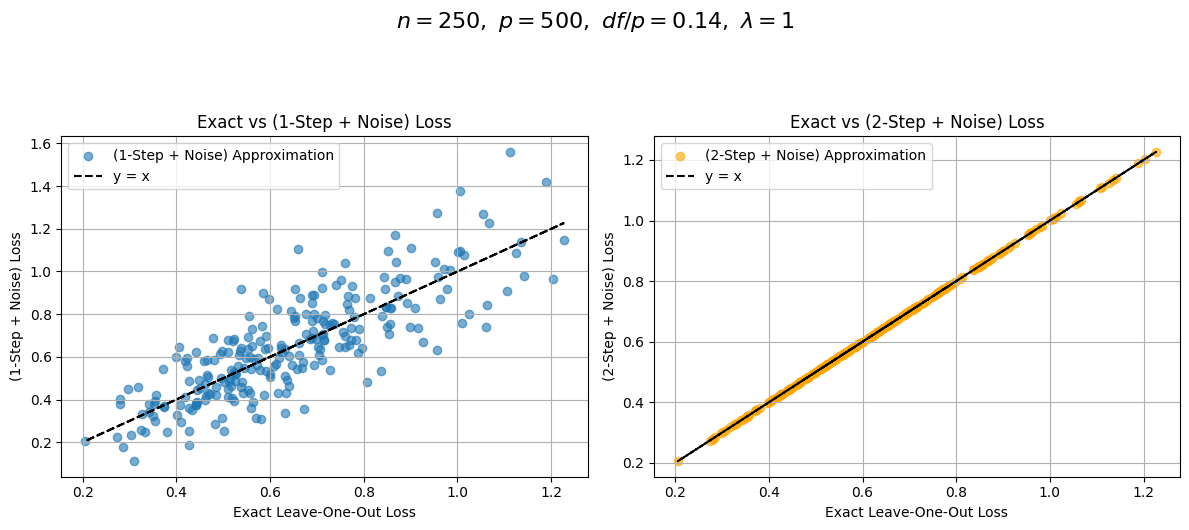

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# --- Create test data ---
n_test = 1000
X_test = np.random.normal(0, 1 / np.sqrt(n), (n_test, p))
logits_test = X_test @ beta_star
y_test = np.random.binomial(1, sigmoid(logits_test))

# --- Metrics ---
def log_loss(y_true, X_data, beta):
    logits = X_data @ beta
    pred = sigmoid(logits)
    pred = np.clip(pred, 1e-10, 1 - 1e-10)  # avoid log(0)
    return -np.mean(y_true * np.log(pred) + (1 - y_true) * np.log(1 - pred))

def error_rate(y_true, X_data, beta):
    prob = sigmoid(X_data @ beta)
    y_pred = (prob >= 0.5).astype(int)
    return np.mean(y_pred != y_true)

# --- Compute Train/Test Loss ---
train_loss_star = log_loss(y, X, beta_star)
train_loss_hat  = log_loss(y, X, beta_hat)
test_loss_star  = log_loss(y_test, X_test, beta_star)
test_loss_hat   = log_loss(y_test, X_test, beta_hat)

# --- Compute Train/Test Error Rate ---
train_error_star = error_rate(y, X, beta_star)
train_error_hat  = error_rate(y, X, beta_hat)
test_error_star  = error_rate(y_test, X_test, beta_star)
test_error_hat   = error_rate(y_test, X_test, beta_hat)

# --- Print All Results ---
print("--- Training and Test Losses ---")
print(f"Train Loss (beta_star): {train_loss_star:.5f}")
print(f"Train Loss (beta_hat) : {train_loss_hat:.5f}")
print(f"Test  Loss (beta_star): {test_loss_star:.5f}")
print(f"Test  Loss (beta_hat) : {test_loss_hat:.5f}")

print("\n--- Classification Error Rates ---")
print(f"Train Error (beta_star): {train_error_star:.4f}")
print(f"Train Error (beta_hat) : {train_error_hat:.4f}")
print(f"Test  Error (beta_star): {test_error_star:.4f}")
print(f"Test  Error (beta_hat) : {test_error_hat:.4f}")

# --- Scatter Plots: Approx vs Exact LOO Loss ---
plt.figure(figsize=(12, 5))

# 1-Step
plt.subplot(1, 2, 1)
plt.scatter(loss_hat, loss_tilde, alpha=0.6, label="(1-Step + Noise) Approximation")
plt.plot(loss_hat, loss_hat, 'k--', label="y = x")
plt.xlabel("Exact Leave-One-Out Loss")
plt.ylabel("(1-Step + Noise) Loss")
plt.title("Exact vs (1-Step + Noise) Loss")
plt.legend()
plt.grid(True)

# 2-Step
plt.subplot(1, 2, 2)
plt.scatter(loss_hat, loss_tilde_2, alpha=0.6, color='orange', label="(2-Step + Noise) Approximation")
plt.plot(loss_hat, loss_hat, 'k--', label="y = x")
plt.xlabel("Exact Leave-One-Out Loss")
plt.ylabel("(2-Step + Noise) Loss")
plt.title("Exact vs (2-Step + Noise) Loss")
plt.legend()
plt.grid(True)

# Title
plt.suptitle(rf'$n = {n},\ p = {p},\ df/p = {tr_H:.2f},\ \lambda = {lambda_}$', fontsize=16, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


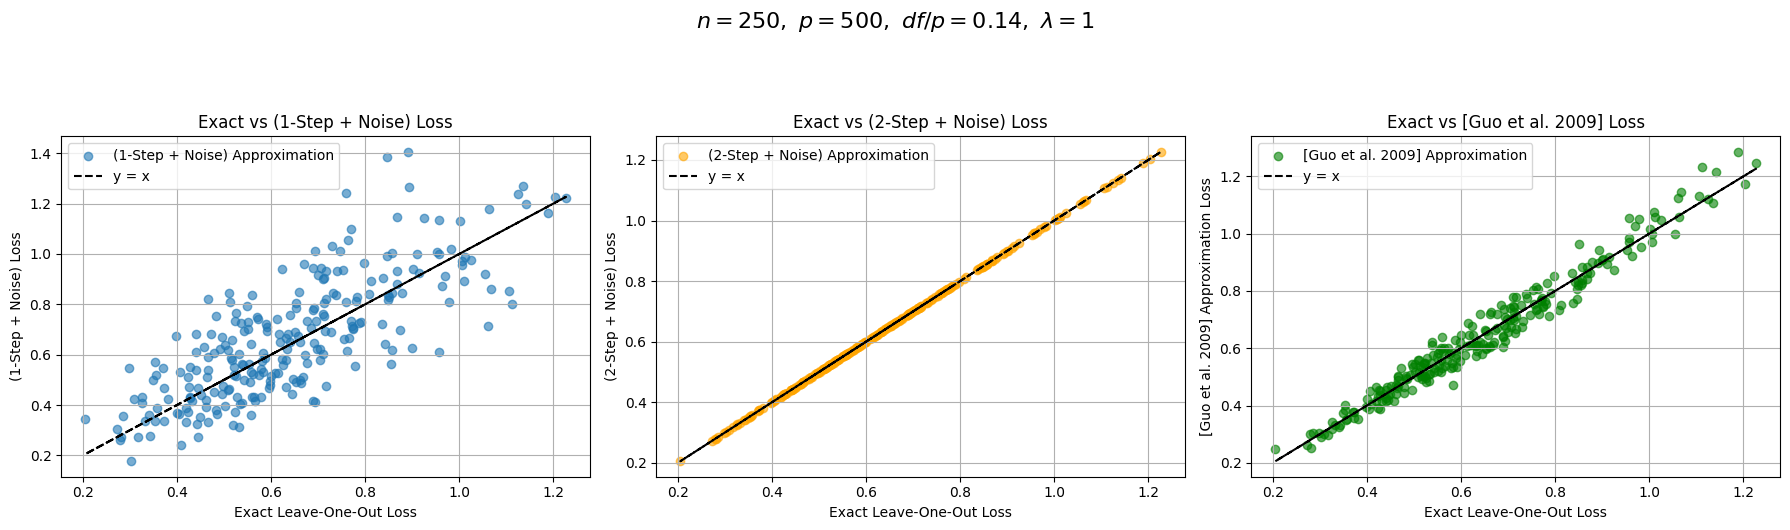

In [39]:
# --- Scatter Plots: Approx vs Exact LOO Loss ---
plt.figure(figsize=(18, 5))

# 1-Step
plt.subplot(1, 3, 1)
plt.scatter(loss_hat, loss_tilde, alpha=0.6, label="(1-Step + Noise) Approximation")
plt.plot(loss_hat, loss_hat, 'k--', label="y = x")
plt.xlabel("Exact Leave-One-Out Loss")
plt.ylabel("(1-Step + Noise) Loss")
plt.title("Exact vs (1-Step + Noise) Loss")
plt.legend()
plt.grid(True)

# 2-Step
plt.subplot(1, 3, 2)
plt.scatter(loss_hat, loss_tilde_2, alpha=0.6, color='orange', label="(2-Step + Noise) Approximation")
plt.plot(loss_hat, loss_hat, 'k--', label="y = x")
plt.xlabel("Exact Leave-One-Out Loss")
plt.ylabel("(2-Step + Noise) Loss")
plt.title("Exact vs (2-Step + Noise) Loss")
plt.legend()
plt.grid(True)

# Guo Approximation
plt.subplot(1, 3, 3)
plt.scatter(loss_hat, loss_Guo, alpha=0.6, color='green', label="[Guo et al. 2009] Approximation")
plt.plot(loss_hat, loss_hat, 'k--', label="y = x")
plt.xlabel("Exact Leave-One-Out Loss")
plt.ylabel("[Guo et al. 2009] Approximation Loss")
plt.title("Exact vs [Guo et al. 2009] Loss")
plt.legend()
plt.grid(True)

# Title
plt.suptitle(rf'$n = {n},\ p = {p},\ df/p = {tr_H:.2f},\ \lambda = {lambda_}$', fontsize=16, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


\begin{eqnarray*}
L(\mathbf{w}, D) &=& \sum_{i=1}^{n} \ell(\mathbf{w}^{\top} \mathbf{x}_i, y_i) + \frac{\lambda n}{2} \|\mathbf{w}\|_2^2,
\\
L(\mathbf{w}, D') &=& \sum_{i=1}^{n-1} \ell(\mathbf{w}^{\top} \mathbf{x}_i, y_i) + \frac{\lambda (n-1)}{2} \|\mathbf{w}\|_2^2 \\
\nabla L(\mathbf{w}, D') &=& \sum_{i=1}^{n-1} \dot{\ell}(\mathbf{w}^{\top} \mathbf{x}_i, y_i) \mathbf{x}_i + \lambda (n-1)\mathbf{w}
\end{eqnarray*}



\begin{eqnarray*}
L(\mathbf{w}, D) &=& \sum_{i=1}^{n} \ell(\mathbf{w}^{\top} \mathbf{x}_i, y_i) + \frac{\gamma}{2} \|\mathbf{w}\|_2^2,
\\
L(\mathbf{w}, D') &=& \sum_{i=1}^{n-1} \ell(\mathbf{w}^{\top} \mathbf{x}_i, y_i) + \frac{\gamma (1-1/n)}{2} \|\mathbf{w}\|_2^2 \\
\nabla L(\mathbf{w}, D') &=& \sum_{i=1}^{n-1} \dot{\ell}(\mathbf{w}^{\top} \mathbf{x}_i, y_i) \mathbf{x}_i + \gamma (1-1/n)\mathbf{w}
\end{eqnarray*}



We assume without loss of generality that we aim to remove the last training sample, $(\mathbf{x}_n, y_n)$.
Specifically, we define an efficient removal mechanism that approximately minimizes $L(\mathbf{w}; D')$.



and the Hessian of $L(\cdot; D')$ at $\mathbf{w^*}$ by
$$
H_{\mathbf{w^*}} = \nabla^2 L(\mathbf{w^*}; D').
$$

We consider the one-step:
$$
\mathbf{w}^{-} =\mathbf{w}^* + H_{\mathbf{w}^*}^{-1} \mathbf{\Delta}.
$$

\begin{eqnarray*}
\left\| \nabla L(\mathbf{w}^{-}; D') \right\|_{2} &=& \left\| \sum_{i=1}^{n-1} \dot{\ell}( \mathbf{x}_i^{\top} \mathbf{w}^{-}, y_i) \mathbf{x}_i + \gamma (1-1/n)\mathbf{w}^{-}  \right\|_{2}
\end{eqnarray*}

(Guo et al. 2019) certified unlearning algorithm:

* Let $\gamma=\lambda n$.

* $\mathbf{w^*} = \arg \min_{\mathbf{w}}  \sum_{i=1}^{n} \ell(\mathbf{w}^{\top} \mathbf{x}_i, y_i) + \frac{\gamma}{2} \|\mathbf{w}\|_2^2$

* $ \mathbf{H}_{\mathbf{w^*}, D'} = \nabla^2 L(\mathbf{w^*}; D')$ with $D' = D \setminus (\mathbf{x}_n, y_n)$.

* Loss gradient at sample $(\mathbf{x}_n, y_n)$: $\mathbf{\Delta} = (\frac{\gamma}{n}) \mathbf{w^*} + \nabla \ell(\mathbf{w^*}^{\top} \mathbf{x}_n, y_n)$

* $\mathbf{w}^{-} =\mathbf{w}^* + \mathbf{H}_{\mathbf{w}^*, D'}^{-1} \mathbf{\Delta}$

* $ \epsilon'=\left\| \nabla L(\mathbf{w}^{-}; D') \right\|_{2} = \left\| \sum_{i=1}^{n-1} \dot{\ell}( \mathbf{x}_i^{\top} \mathbf{w}^{-}, y_i) \mathbf{x}_i + \gamma (1-1/n)\mathbf{w}^{-}  \right\|_{2}$

* Set $\delta=0.00001$, $c = \sqrt{2 \log (1.5/\delta)}$, and $\epsilon=0.1$ and $\sigma=c \epsilon'/\epsilon$.

* Draw $\mathbf{b} \sim N(0, \sigma)^d$


* Solve \begin{eqnarray*}
L_{\mathbf{b}}(\mathbf{w}, D) &=& \sum_{i=1}^{n} \ell(\mathbf{w}^{\top} \mathbf{x}_i, y_i) + \frac{\gamma}{2} \|\mathbf{w}\|_2^2 + \mathbf{b}^\top \mathbf{w},
\\
\mathbf{w}_{\mathbf{b}} &=& \arg \min_{\mathbf{w}} L_{\mathbf{b}}(\mathbf{w}, D).
\end{eqnarray*}

* $\mathbf{\Delta}_{\mathbf{b}} := (\frac{\gamma}{n}) \mathbf{w}_{\mathbf{b}} + \nabla \ell(\mathbf{w}_{\mathbf{b}}^{\top} \mathbf{x}_n, y_n)$

* $ \mathbf{H}_{\mathbf{w}_{\mathbf{b}}, D'} = \nabla^2 L(\mathbf{w}_{\mathbf{b}}; D').$

* $\mathbf{w}_{Guo}^{-} = \mathbf{w_b} + \mathbf{H}_{\mathbf{w}_{\mathbf{b}}, D'}^{-1} \mathbf{\Delta}_{\mathbf{b}} $

